# Algorithmic Methods of Data Mining 2019/2020
## Homework 2 - Nicola Bonardo
## Soccer analytics

This notebook is intended to work with dataset in json format, downloaded from the [website](https://figshare.com/collections/Soccer_match_event_dataset/4415000) indicated in the homework text, and put in a sub-folder 'data' of the folder where the notebook is executed from.

Loading of the libraries that will be used.

In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# RQ1

In [2]:
df_matches_eng = pd.read_json(r'data\matches_England.json') #380 rows

Text(0.5, 1.0, 'Premier League 2017/2018 - Points by Team and Week')

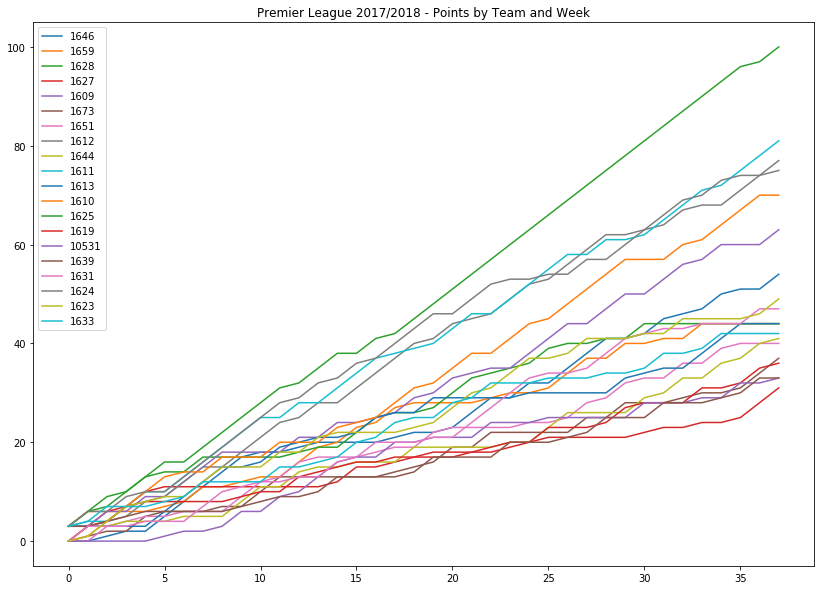

In [3]:
teamsPoints = defaultdict(list)
for i in range(0, df_matches_eng.shape[0]):    
    teamsData = df_matches_eng.iloc[i,10]
    teamsIds = list(teamsData.keys())    
    if teamsData[teamsIds[0]]['score'] > teamsData[teamsIds[1]]['score']:    
        teamsPoints[teamsIds[0]].append(3)
        teamsPoints[teamsIds[1]].append(0)
    elif teamsData[teamsIds[0]]['score'] < teamsData[teamsIds[1]]['score']:    
        teamsPoints[teamsIds[0]].append(0)
        teamsPoints[teamsIds[1]].append(3)
    else:    
        teamsPoints[teamsIds[0]].append(1)
        teamsPoints[teamsIds[1]].append(1) 

tdf = pd.DataFrame(teamsPoints)
fig=plt.figure()
fig.set_size_inches(14, 10)
plt.plot(tdf.cumsum())
plt.legend(tdf.cumsum().columns)
plt.title("Premier League 2017/2018 - Points by Team and Week")

# RQ 2

To check for a home-field advantage, we choose 5 teams, with id's listed in *rq2_teams*. Then, for each of the teams, we subset the dataframe of the english matches using a function that checks if a match row regards the specified team. If this is the case, the outcome (win/draw/lost) and side (home/away) is stored in a dataframe. Using the **crosstab** function it is then possibile to create a contingency table, containing the number of occurrencies of each combination. 

In [4]:
# function used to subset the dataframe containing all of the matches
def check_if_match_of_team(row, teamId):
    return(teamId in row.teamsData.keys())  

# list of the teams to analyse
rq2_teams = ['1619', '1625', '1659', '1611', '1673']

for team in rq2_teams: 
    # subsetting of the df_matches_eng dataframe, creating a dataframe of matches of the team 
    mask = df_matches_eng.apply(lambda row: check_if_match_of_team(row, team), axis=1)
    df_matches_team = df_matches_eng[mask]

    # creation of a list of dict with the outcome and side of each match
    rows_list = []
    for i in range(0, df_matches_team.shape[0]):
        winner = str(df_matches_team.iloc[i, 12])        
        teamsData = df_matches_team.iloc[i,10]    
        outcome = ""
        if winner == team:
            outcome = 'win'
        elif winner == '0':
            outcome = 'draw'
        else:
            outcome = 'lost'

        m_dict = {'outcome':outcome, 'side':teamsData[team]['side']}
        rows_list.append(m_dict)
    
    # creation of a dataframe from the list of dicts, and creation of the contingency table        
    df_outcomes = pd.DataFrame(rows_list)
    print("Team: ", team)
    print(pd.crosstab(df_outcomes.outcome, df_outcomes.side))
    print("***")    

Team:  1619
side     away  home
outcome            
draw        8     7
lost        8     8
win         3     4
***
Team:  1625
side     away  home
outcome            
draw        2     2
lost        1     1
win        16    16
***
Team:  1659
side     away  home
outcome            
draw        6     5
lost        9     7
win         4     7
***
Team:  1611
side     away  home
outcome            
draw        4     2
lost        5     2
win        10    15
***
Team:  1673
side     away  home
outcome            
draw        5     5
lost       11     8
win         3     6
***


# RQ3 

In order to show the distribution of the ages of all the coaches in Premier League, first of all we use the matches_England dataset to identify all of the coaches involved in matches. Some data cleaning is needed: there is a coachId (3782) with no corrispondence in the coaches dataset; moreover the coach A. Conte is repeated twice. In the end, 32 coaches are found.

In [5]:
df_teams = pd.read_json(r'data\teams.json')
df_coaches = pd.read_json(r'data\coaches.json')

In [6]:
# building a list of wyId's of all of the coaches of english teams
all_coaches_eng = []
for row in df_matches_eng.teamsData:
    for key in row.keys():
        coachId = row[key]['coachId']
        if  coachId != 0 and coachId not in all_coaches_eng:
            all_coaches_eng.append(coachId)
# there is no coach with wyId = 3782 in df_coaches
all_coaches_eng.remove(3782)
# A. Conte is repeated twice (ids 20454 and 272869)
all_coaches_eng.remove(272869)

# Filtering the coaches dataframe leaving only the coaches from the list of english teams's coaches
mask = df_coaches.wyId.apply(lambda x : x in all_coaches_eng)
df_coaches_eng = df_coaches[mask]

In [7]:
df_youngest10 = df_coaches_eng.sort_values(by=['birthDate'], ascending=False).head(10)
df_youngest10[['shortName', 'birthDate']]

,shortName,birthDate
56,E. Howe,1977-11-29
170,Marco Silva,1977-07-12
131,M. Appleton,1975-12-04
133,D. Unsworth,1973-10-16
73,Paco,1973-02-19
90,M. Pochettino,1972-03-02
148,P. Clement,1972-01-08
29,D. Wagner,1971-10-19
48,M. Pellegrino,1971-10-05
87,S. Dyche,1971-06-28


Now for each coach we will use the datetime module to calculate the age, in years. With the resulting list it is possible to plot a **boxplot**.

{'whiskers': [<matplotlib.lines.Line2D at 0xa42cc50>,
 'caps': [<matplotlib.lines.Line2D at 0xa6bed30>,
 'boxes': [<matplotlib.lines.Line2D at 0xa6be2b0>],
 'medians': [<matplotlib.lines.Line2D at 0xa6c7400>],
 'fliers': [<matplotlib.lines.Line2D at 0xa6c7748>],
 'means': []}

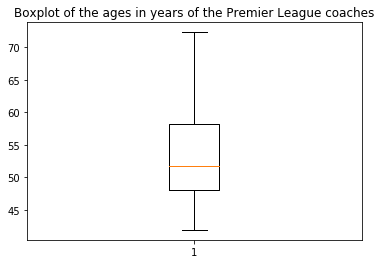

In [8]:
ages = []
for date in df_coaches_eng.birthDate:
    dateobj = datetime.strptime(date, "%Y-%m-%d")
    age = datetime.now() - dateobj
    ages.append(age.total_seconds() / (3600*24*365))

_, ax_bp = plt.subplots()
ax_bp.set_title('Boxplot of the ages in years of the Premier League coaches')
ax_bp.boxplot(ages)

# RQ4

In order to find the **top 10 players** with the highest ration between **completed passes** and **attempted passes**, first of all we will load the events_England dataset into a dataFrame, and we will subset it leaving only the **passes**, e.g. events with eventId = 8. 

To avoid meaningless results, a threshold of 19 minimum attemps is set.

In [9]:
# We will load the events_England dataset
df_eventsEng = pd.read_json(r'data\events_England.json') #643150 events

In [10]:
df_eventsEngPasses = df_eventsEng[df_eventsEng.eventId == 8] #328657

def checkAccurate(row):
    for tag in row.tags:
        if tag['id'] == 1801:
            return(True)
    return(False)

df_eventsEngPasses['accurate'] = df_eventsEngPasses.apply(lambda row: checkAccurate(row), axis=1)

C:\Users\nbonardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
passesGrouping = df_eventsEngPasses.groupby('playerId').accurate.value_counts()

min_attempts = 19
player_accuracy = {}
for idx, data in passesGrouping.groupby(level=0):
    if len(data) == 2 and data[0]+data[1] > min_attempts:        
        player_accuracy[idx] = data[0]/(data[0]+data[1])  

sortedPlayers = sorted(player_accuracy.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
top10 = sortedPlayers[:10]
for player in top10:
    print(player[0])            

9380
14886
8324
8464
8307
135103
7856
7918
70086
120339


# CRQ1 

[CRQ1] What are the time slots of the match with more goals? Let's analyse and visualise the goals distribution into 9-minutes sets for all the matches. I.e., let's transform the minute of a goal from a continuous variable in a discrete variable (e.g. A goal scored in 5th minute, will end up in the interval [0-9)). Remind that every match goes usually from minute 0, to minute 90, but in football it is always added an arbitary amount of extra-time to every half of the match, thus consider also the intervals "45+" and "90+".

    Make a barplot with the absolute frequency of goals in all the time slots.
    Find the top 10 teams that score the most in the interval "81-90".
    Show if there are players that were able to score at least one goal in 8 different intervals

In [12]:
# I am excluding own-goals 102 because they are not relevant.
def filter_goals(row):
    if row.eventName == 'Shot':
        for tag in row.tags:
            if tag['id'] == 101:
                return True    
    return False

mask = df_eventsEng.apply(filter_goals, axis=1)
df_goals_eng = df_eventsEng[mask]

C:\Users\nbonardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


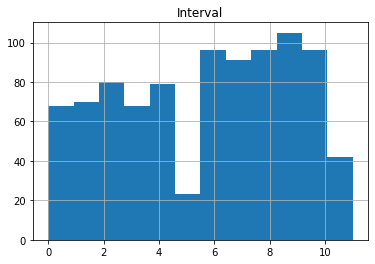

In [13]:
import math
def get_interval(sec, period):
    if period == '1H':        
        return math.floor(sec / (60*9))
    elif period == '2H':
        return math.floor(sec / (60*9)) + 6

df_goals_eng['Interval'] = df_goals_eng.apply(lambda x: get_interval(x['eventSec'], x['matchPeriod']), axis=1)
plot = pd.DataFrame.hist(df_goals_eng, 'Interval', bins=12)

### Find the top 10 teams that score the most in the interval "81-90".

In [14]:
df_top10 = df_goals_eng[df_goals_eng.Interval == 11]
freq = df_top10["teamId"].value_counts()
list(freq[:12].index)
# I selected 12 teams beacuse there are 5 teams with the same frequency (2). 

[1631, 1625, 1659, 1644, 1628, 1624, 1611, 1673, 1627, 1623, 1612, 1609]

### Show if there are players that were able to score at least one goal in 8 different intervals

In [15]:
x = df_goals_eng.groupby('playerId').Interval.nunique()
x[x>7]

playerId
3324       9
7905       9
8422       8
8717      10
11066     11
12829      9
14703      8
15808      8
25413      8
26150      9
120353    11
340386     9
Name: Interval, dtype: int64

# CRQ2

In [16]:
import seaborn as sns
from matplotlib.patches import Arc, Rectangle, ConnectionPatch

In [17]:
def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

Considering only the match Barcelona - Real Madrid played on the 6 May 2018:
visualize with a heatmap the zones where Cristiano Ronaldo was more active. 
The events to be considered are: passes, shoots, duels, free kicks

In [18]:
df_matches_spain = pd.read_json(r'data\matches_Spain.json')

Analyzing the columns (eg. competitionId, seasonId) with df_matches_spain.<column_name>.nunique() I decided to keep only a subset of the columns where the data was significant.

In [19]:
df_matches_spain_simple = df_matches_spain[['dateutc', 'gameweek', 'label', 'teamsData', 'wyId']]

Looking at the dataFrame, it is easily found that the match we are interested in (Barcelona - Real Madrid, 06/05/2018) has wyId = 2565907

In [20]:
df_matches_spain_simple[df_matches_spain_simple.wyId == 2565907]

,dateutc,gameweek,label,teamsData,wyId
23,2018-05-06 18:45:00,36,"Barcelona - Real Madrid, 2 - 2","{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",2565907


Using the players dataset, we can find the wyId's of the players we are interested in: **Cristiano Ronaldo** has a wyId = 3322 while **Lionel Messi** has wyId = 3359.

In [21]:
df_players = pd.read_json(r'data\players.json')
df_players[(df_players.shortName == "Cristiano Ronaldo") | (df_players.shortName == "L. Messi")][['shortName', 'wyId']]

,shortName,wyId
185,Cristiano Ronaldo,3322
207,L. Messi,3359


Now we can create a subset of the events_Spain dataset, selecting first of all the events for matchId = 2565907, and then creating dataframes for events related to Cristiano Ronaldo (playerId = 3322) and Lionel Messi (playerId = 3359), in both cases considering only events with eventId = 1 (Duels), 3 (Free Kicks), 8 (Passes) and 10 (Shots).

In [22]:
df_events_spain = pd.read_json(r'data\events_Spain.json')
df_events_BRM = df_events_spain[df_events_spain.matchId == 2565907]
df_events_BRM_sel = df_events_BRM[(df_events_BRM.eventId == 1) | (df_events_BRM.eventId == 3) 
                                 | (df_events_BRM.eventId == 8) | (df_events_BRM.eventId == 10)]

In [23]:
df_events_CriRon = df_events_BRM[df_events_BRM.playerId == 3322]

In [24]:
df_events_LioMes = df_events_BRM[df_events_BRM.playerId == 3359]

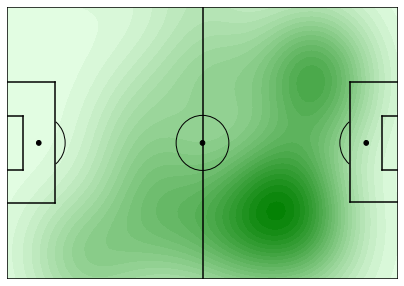

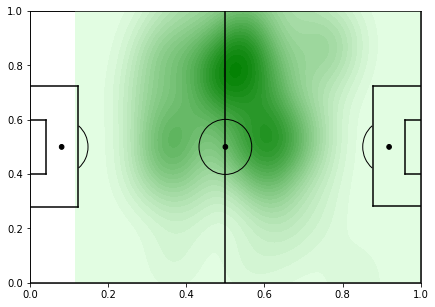

In [25]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.axis('off')

x_coord = [i[0]['x'] for i in df_events_CriRon["positions"]]
y_coord = [i[0]['y'] for i in df_events_CriRon["positions"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more bluerry it loos

sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)
plt.ylim(0, 80) # need this, otherwise kde plot will go outside
plt.xlim(0, 120)
#plt.show()

fig, ax = plt.subplots()

fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.axis('off')

#fig, ax = plt.subplots()
#fig.set_size_inches(7, 5)

x_coord = [i[0]['x'] for i in df_events_LioMes["positions"]]
y_coord = [i[0]['y'] for i in df_events_LioMes["positions"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more bluerry it loos

sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)
plt.ylim(0, 80) # need this, otherwise kde plot will go outside
plt.xlim(0, 120)
plt.show()

Considering only the match Juventus - Napoli played on the 22 April 2018:

    visualize with arrows the starting point and ending point of each pass done during the match by Jorginho and Miralem Pjanic. Is there a huge difference between the map with all the passes done and the one with only accurate passes? Comment the results and point out the main differences.


First of all, we need to identify the matchId of Juventus - Napoli on 22/04/2018. We find that its wyId is 2576295.

In [26]:
df_matches_italy = pd.read_json(r'data\matches_Italy.json')
df_matches_italy[df_matches_italy.label.str.contains('Juventus - Napoli')]

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
41,524,"April 22, 2018 at 8:45:00 PM GMT+2",2018-04-22 18:45:00,Regular,34,"Juventus - Napoli, 0 - 1","[{'refereeId': 377206, 'role': 'referee'}, {'r...",4406278,181248,Played,"{'3159': {'scoreET': 0, 'coachId': 20386, 'sid...",,3187,2576295


Now we need to load the events for the italian championship into a dataframe, and then subsetting it considering only the events for the match we are interested in (matchId = 2576295) and considering only the passes, that is the events with eventId = 8.

In [27]:
df_events_italy = pd.read_json(r'data\events_italy.json')

In [28]:
df_events_JN = df_events_italy[(df_events_italy.matchId == 2576295) & (df_events_italy.eventId == 8)]

We will use the previously loaded players' dataframe to identify wyId's for Jorginho and M. Pjanic.

In [29]:
df_players[(df_players.shortName == "Jorginho") | (df_players.firstName == "Miralem")][['shortName', 'wyId']]

,shortName,wyId
1482,M. Pjani\u0107,20443
1658,Jorginho,21315


In [30]:
df_events_Jorginho = df_events_JN[df_events_JN.playerId == 21315]

In [31]:
df_events_Pjanic = df_events_JN[df_events_JN.playerId == 20443]

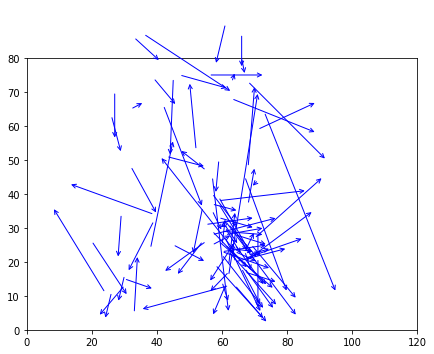

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.set_xlim([0,120])
ax.set_ylim([0,80])
for i in range(len(df_events_Jorginho)):
    positions = df_events_Jorginho.iloc[i].positions
    # can also differentiate by color
    color = "blue" if df_events_Jorginho.iloc[i]['matchPeriod'] == '1H' else "red"
    ax.annotate("", 
                xy = (positions[1]['x'], positions[1]['y']), 
                xycoords = 'data',
                xytext = (positions[0]['x'], positions[0]['y']), 
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
plt.show()